In [1]:
import numpy as np
import pandas as pd
import rioxarray as rioxr
import xarray as xr
import matplotlib.pyplot as plt
import os
import gc
import geopandas as gpd
import threading
from dask.distributed import Client, LocalCluster, Lock
from dask.utils import SerializableLock
from datetime import datetime
from dask.diagnostics import ProgressBar
from rioxarray.merge import merge_arrays, merge_datasets
from ipywidgets import IntProgress
from IPython.display import display
import time
from distributed.client import _global_clients
from tqdm.notebook import trange, tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep
from datetime import date
from shapely.geometry import mapping
import warnings
from functools import reduce

##### -----------------------<i>This code will require a good amount of modification to run------------------------

In [2]:
data_vars = ['erc', 'etr', 'fm100', 'fm1000', 'pet', 'pr', 'rmax', 'rmin', 'sph', 'srad', 'th', 'tmmn', 'tmmx', 'vpd', 'vs']  

In [3]:
permits = gpd.read_file('C:\\Users\\rmonaghan\\Desktop\\Projects\\GRIDMET\\Data\\FL_permits\AllStates_Burn_NoSugarC.shp', engine='pyogrio')

In [4]:
# Florida Forest Service Districts
### RASTERS LOCATED HERE: "F:\RMonaghan_Workspace\Projects_Main\GM\Data\GRIDMET_files\tif.zip"
ffs = gpd.read_file("", engine='pyogrio')
wfires = gpd.read_file("", layer="Fires", engine='pyogrio')

In [4]:
permits['DATE'] = pd.to_datetime(permits['DATE']) # making sure the DT field is recognized as a DT attribute
permits['YEAR'] = permits['DATE'].dt.year # extracting the year from the DATE column and saving it to another column

114896

In [5]:
# FOR PERMITS

# function to subset input df by year
def get_files(inDir, var, year):
	for file in os.listdir(inDir):
		if file.startswith(f"{var}"):
			if f"{year}" in file:
				fp = os.path.join(inDir.replace('\\','/')  + file)
	return fp

# open up GM and clip to unique query points
def preprocess_raster(file, year, var):
	with LocalCluster() as cluster, Client(cluster) as client:
		pquery = permits.query(f'YEAR == {year} & ACRES.notnull() & ACRES > 0.0 & STATE == "FL"').to_crs('EPSG:4326')
		pcopy = pquery.drop_duplicates(subset=['LATITUDE', 'LONGITUDE', 'DATE'])

		data = rioxr.open_rasterio(file, nodata=None, mask_and_scale=True).rio.clip(pcopy.geometry.apply(mapping), drop=True, invert=False)  #.isel(day=slice(0,365))
		data = data.where(data != data.rio.nodata)
			
		ds = data.to_dataset(name=var)

		return ds, pcopy

# flattening multidimensional data
def flatten(ds):
	df = ds.to_dataframe()
	return df

# process time -- originally in df as days since 1/1/1900
def preprocess_df(df):
	warnings.filterwarnings("ignore")
	
	df.reset_index(inplace=True)
	start_date = date(1900,1,1)
	df['to_date'] = df.loc[:,'day'].str.replace('.','').astype(int)
	df.loc[:,'to_date'] = pd.to_timedelta(df.loc[:,'to_date'], unit='D')
	df['start_date'] = start_date
	df['since_date'] = pd.to_datetime(df['start_date'] + df['to_date'])

	return df

# turn pandas df in geopandas (spatially-enabled) gdf
def concatenate_and_make_spatial(preprocessed_df, var):
    gdf = gpd.GeoDataFrame(preprocessed_df, geometry=gpd.points_from_xy(preprocessed_df.x, preprocessed_df.y)).set_crs('EPSG:4326').to_crs('EPSG:26717')
    gdf_no_fill = gdf[gdf[f"{var}"] != 32767]                                                         
    gdf_not_null = gdf_no_fill.dropna(subset=f"{var}")                                                
    	
    return gdf_not_null
	
# call funcs a year at a time
def call_functions(var, inDir):
	years = np.arange(2010,2021,1)
	with tqdm(total=len(years)) as pbar:
		for year in years:
			pbar.set_description(f"Processing {var} for {year}")
			file = get_files(inDir, var, year)
			praster, pcopy = preprocess_raster(file, year, var)
			pcopy = pcopy.to_crs('EPSG:26717')
			df = flatten(praster)
			pdf = preprocess_df(df)
			gdf = concatenate_and_make_spatial(pdf, f"{var}")

			sjoined = gpd.sjoin_nearest(gdf, pcopy, how="right").loc[lambda x: x["DATE"].eq(x["since_date"])]
			sjoined.to_csv(f"C:/Users/rmonaghan/Desktop/Projects/GRIDMET/Exports/GRIDMET_Permit_Sampled_CSVs/{var}_permits_export_{year}.csv")
			pbar.update(1)

In [ ]:
data_vars = ['pet', 'pr', 'rmax', 'rmin', 'sph', 'srad', 'th', 'tmmn', 'tmmx', 'vpd', 'vs', 'erc', 'etr', 'fm100', 'fm1000']

inDir = "F:/RMonaghan_Workspace/Projects/GRIDMET.SE_Burn_Permits/Data/GRIDMET_files/tif/Var_each_Year/"

for var in data_vars:
    call_functions(var, inDir)

In [5]:
# FOR WILDFIRES

# function to subset input df by year
def get_files_wf(inDir, var, year):
	for file in os.listdir(inDir):
		if file.startswith(f"{var}"):
			if f"{year}" in file:
				fp = os.path.join(inDir.replace('\\','/')  + file)
	return fp

def preprocess_raster_wf(file, year, var):
	with LocalCluster() as cluster, Client(cluster) as client:
		# string = f'DATE == {year} & ACRES.notnull() & ACRES > 0.0 & STATE == "FL"'
		wf_query = wfires.query(f'FIRE_YEAR == {year} & FIRE_SIZE >= 1.0 & STATE == "FL"')
		wf_copy = wf_query.drop_duplicates(subset=['LATITUDE', 'LONGITUDE', 'DISCOVERY_DATE']).to_crs('EPSG:4326').copy()

		data = rioxr.open_rasterio(file, nodata=None, mask_and_scale=True).rio.clip(wf_copy.geometry.apply(mapping), drop=True, invert=False)  #.isel(day=slice(0,365))
		data = data.where(data != data.rio.nodata)
			
		ds = data.to_dataset(name=var)

		return ds, wf_copy

# open up GM and clip to unique query points
def preprocess_raster_wf(file, year, var):
	with LocalCluster() as cluster, Client(cluster) as client:
		pquery = permits.query(f'YEAR == {year} & ACRES.notnull() & ACRES > 0.0 & STATE == "FL"').to_crs('EPSG:4326')
		pcopy = pquery.drop_duplicates(subset=['LATITUDE', 'LONGITUDE', 'DISCOVERY_DATE'])

		data = rioxr.open_rasterio(file, nodata=None, mask_and_scale=True).rio.clip(pcopy.geometry.apply(mapping), drop=True, invert=False)  #.isel(day=slice(0,365))
		data = data.where(data != data.rio.nodata)
			
		ds = data.to_dataset(name=var)

		return ds, pcopy

# flattening multidimensional data
def flatten_wf(ds):
	df = ds.to_dataframe()
	return df

# process time -- originally in df as days since 1/1/1900
def preprocess_df_wf(df):
	warnings.filterwarnings("ignore")
	
	df.reset_index(inplace=True)
	start_date = date(1900,1,1)
	df['to_date'] = df.loc[:,'day'].str.replace('.','').astype(int)
	df.loc[:,'to_date'] = pd.to_timedelta(df.loc[:,'to_date'], unit='D')
	df['start_date'] = start_date
	df['since_date'] = pd.to_datetime(df['start_date'] + df['to_date'])

	return df

# turn pandas df in geopandas (spatially-enabled) gdf
def concatenate_and_make_spatial_wf(preprocessed_df, var):
    gdf = gpd.GeoDataFrame(preprocessed_df, geometry=gpd.points_from_xy(preprocessed_df.x, preprocessed_df.y)).set_crs('EPSG:4326').to_crs('EPSG:26717')
    gdf_no_fill = gdf[gdf[f"{var}"] != 32767]                                                         
    gdf_not_null = gdf_no_fill.dropna(subset=f"{var}")                                                
    	
    return gdf_not_null

# call funcs a year at a time
def call_functions_wf(var, inDir):
	years = np.arange(2010,2021,1)
	with tqdm(total=len(years)) as pbar:
		for year in years:
			pbar.set_description(f"Processing {var} for {year}")
			file = get_files_wf(inDir, var, year)
			praster, pcopy = preprocess_raster_wf(file, year, var)
			pcopy = pcopy.to_crs('EPSG:26717')
			df = flatten_wf(praster)
			pdf = preprocess_df_wf(df)
			gdf = concatenate_and_make_spatial_wf(pdf, f"{var}")

			sjoined = gpd.sjoin_nearest(gdf, pcopy, how="right").loc[lambda x: x["DISCOVERY_DATE"].eq(x["since_date"])]
			sjoined.to_csv(f"C:/Users/rmonaghan/Desktop/Projects/GRIDMET/Exports/GRIDMET_Wildfire_Sampled_CSVs/{var}_wildfire_export_{year}.csv")
			pbar.update(1)

inDir = ""
data_vars = ["pet", "pr", 'rmax', 'rmin', 'sph', 'srad', 'th', 'tmmn', 'tmmx', 'vpd', 'vs', 'erc', 'etr', 'fm100', 'fm1000']

for var in data_vars:
    call_functions_wf(var, inDir)

In [ ]:
inDir = ""
data_vars = ["pet", "pr", 'rmax', 'rmin', 'sph', 'srad', 'th', 'tmmn', 'tmmx', 'vpd', 'vs', 'erc', 'etr', 'fm100', 'fm1000']

for var in data_vars:
    call_functions_wf(var, inDir)

In [18]:
# this code is for retrieving values from separate csvs saved for var + year --> there is now a full GM dataset that can be used instead

path = ""
def retrieve_csvs_year(year):
    res = []
    for r, d, f in os.walk(path):
        for file in f:
            if f"{year}" in file:
                x = pd.read_csv(os.path.join(r, file)).reset_index()
                res.append(x)
    
    dfs = reduce(lambda x, y: pd.merge(x, y, on = ['x', 'y', 'start_date', 'since_date', 'STATE', 'BURN_TYPE', 'DATE', 'YEAR', 'ACRES', 'LATITUDE', 'LONGITUDE', 'SOURCE']), res)
    dfs = dfs[['x', 'y',"pet", "pr", 'rmax', 'rmin', 'sph', 'srad', 'th', 'tmmn', 'tmmx', 'vpd', 'vs', 'erc', 'etr', 'fm100', 'fm1000', 'DATE', 'YEAR', 'STATE', 'BURN_TYPE', 'ACRES', 'SOURCE', 'LATITUDE', 'LONGITUDE', 'geometry']]
    return dfs

In [19]:
path = ""
years = np.arange(2010, 2021, 1)
dfs = []
for year in years:
    opened = retrieve_csvs_year(year)
    dfs.append(opened)

concatenated = pd.concat(dfs)
gdfs = gpd.GeoDataFrame(concatenated, geometry=gpd.points_from_xy(concatenated.LONGITUDE, concatenated.LATITUDE), crs='EPSG:4326')

In [20]:
gdfs.columns
gdfs.to_csv('')


(Index(['x', 'y', 'pet', 'pr', 'rmax', 'rmin', 'sph', 'srad', 'th', 'tmmn',
        'tmmx', 'vpd', 'vs', 'erc', 'etr', 'fm100', 'fm1000', 'DATE', 'YEAR',
        'STATE', 'BURN_TYPE', 'ACRES', 'SOURCE', 'LATITUDE', 'LONGITUDE',
        'geometry'],
       dtype='object'),
 124549)

In [37]:
exp_df = pd.read_csv("")
exp_gdf = gpd.GeoDataFrame(exp_df, geometry=gpd.points_from_xy(exp_df['LONGITUDE'], exp_df['LATITUDE']), crs='EPSG:4326')

In [44]:
exp_gdf['DATE'] = pd.to_datetime(exp_gdf['DATE'])
exp_gdf['YEAR'] = exp_gdf['DATE'].dt.year

In [16]:
# scaling and offset factors based on file metadata

wfires['tmmn_F'] = ((wfires['tmmn'] * 0.1 + 220) - 273.15) * 9/5 + 32
wfires['tmmx_F'] = ((wfires['tmmx'] * 0.1 + 220) - 273.15) * 9/5 + 32
wfires['etr_mm_scaled'] = wfires['etr'] * 0.1
wfires['fm100_pct_scaled'] = wfires['fm100'] * 0.1
wfires['fm1000_pct_scaled'] = wfires['fm1000'] * 0.1
wfires['pet_mm_scaled'] = wfires['pet'] * 0.1
wfires['pr_mm_scaled'] = wfires['pr'] * 0.1
wfires['rmin_pct_scaled'] = wfires['rmin'] * 0.1
wfires['rmax_pct_scaled'] = wfires['rmax'] * 0.1
wfires['sph_kg_per_kg'] = wfires['sph'] * 0.00001
wfires['srad_W_per_m2'] = wfires['srad'] * 0.1
wfires['th_deg_clockwise_from_N'] = wfires['th']
wfires['vs_m_per_s'] = wfires['vs'] * 0.1
wfires['vpd_kPA'] = wfires['vpd'] * 0.1
wfires['erc_g_unitless'] = wfires['erc']

In [64]:
# aggregating by FFS district (unused)
wfires_gdf = gpd.GeoDataFrame(wfires, geometry=gpd.points_from_xy(wfires.LONGITUDE, wfires.LATITUDE), crs='EPSG:4326').to_crs('EPSG:26717')
ffs = gpd.read_file("").to_crs('EPSG:26717')
ffs_d = ffs.dissolve('DOF_DISTRI').copy()

In [67]:
wfires_sjoined = wfires_gdf.sjoin_nearest(ffs_d.reset_index()[['DOF_DISTRI', 'geometry']])

In [70]:
wfires_sjoined

Unnamed: 0          x          y   pet     pr    rmax   rmin     sph  \
0               0 -82.391667  30.316667  23.0    0.0   600.0  205.0   160.0   
1               1 -82.558333  30.358333  23.0    0.0   573.0  204.0   159.0   
2               2 -82.350000  30.358333  17.0    0.0  1000.0  307.0   415.0   
18             18 -82.266667  30.316667  47.0  190.0   999.0  485.0  1462.0   
19             19 -82.475000  30.316667  61.0    0.0   924.0  311.0   856.0   
...           ...        ...        ...   ...    ...     ...    ...     ...   
20479        1213 -87.225000  30.691667  42.0    0.0   822.0  382.0   928.0   
20506        1240 -86.808333  30.483333  58.0    0.0   845.0  373.0   908.0   
20507        1241 -86.850000  30.483333  44.0    0.0   911.0  249.0   512.0   
20508        1242 -86.850000  30.483333  51.0    0.0   802.0  465.0  1144.0   
20509        1243 -86.766667  30.441667  61.0    0.0   929.0  523.0  1312.0   

         srad     th  ...  rmin_pct_scaled  rmax_pct_scaled  sph_kg_per_kg  \
0      1758.0  290.0  ...             20.5             60.0        0.00160   
1      1753.0  292.0  ...             20.4             57.3        0.00159   
2      1044.0   14.0  ...             30.7            100.0        0.00415   
18     2291.0  100.0  ...             48.5             99.9        0.01462   
19     3392.0   83.0  ...             31.1             92.4        0.00856   
...       ...    ...  ...              ...              ...            ...   
20479  2361.0  183.0  ...             38.2             82.2        0.00928   
20506  3138.0  148.0  ...             37.3             84.5        0.00908   
20507  1851.0   19.0  ...             24.9             91.1        0.00512   
20508  2532.0  151.0  ...             46.5             80.2        0.01144   
20509  3398.0  126.0  ...             52.3             92.9        0.01312   

       srad_W_per_m2  th_deg_clockwise_from_N  vs_m_per_s  vpd_kPA  \
0              175.8                    290.0         4.0      5.0   
1              175.3                    292.0         4.0      5.1   
2              104.4                     14.0         1.7      6.6   
18             229.1                    100.0         3.0     10.3   
19             339.2                     83.0         3.8     12.5   
...              ...                      ...         ...      ...   
20479          236.1                    183.0         2.3     11.7   
20506          313.8                    148.0         4.4     11.4   
20507          185.1                     19.0         6.6      9.8   
20508          253.2                    151.0         4.8     11.0   
20509          339.8                    126.0         6.9      8.9   

       erc_g_unitless  index_right  DOF_DISTRI  
0                34.0           11    Suwannee  
1                35.0           11    Suwannee  
2                33.0           11    Suwannee  
18               17.0           11    Suwannee  
19               32.0           11    Suwannee  
...               ...          ...         ...  
20479            37.0            0  Blackwater  
20506            33.0            0  Blackwater  
20507            33.0            0  Blackwater  
20508            34.0            0  Blackwater  
20509            36.0            0  Blackwater  

[20560 rows x 55 columns]

In [39]:
wfires_sjoined.columns

Index(['Unnamed: 0', 'x', 'y', 'pet', 'pr', 'rmax', 'rmin', 'sph', 'srad',
       'th', 'tmmn', 'tmmx', 'vpd', 'vs', 'erc', 'etr', 'fm100', 'fm1000',
       'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_UNIT_NAME', 'FIRE_NAME', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'COUNTY',
       'geometry', 'tmmn_F', 'tmmx_F', 'etr_mm_scaled', 'fm100_pct_scaled',
       'fm1000_pct_scaled', 'pet_mm_scaled', 'pr_mm_scaled', 'rmin_pct_scaled',
       'rmax_pct_scaled', 'sph_kg_per_kg', 'srad_W_per_m2',
       'th_deg_clockwise_from_N', 'vs_m_per_s', 'vpd_kPA', 'erc_g_unitless',
       'index_right', 'DOF_DISTRI'],
      dtype='object')

In [77]:
wfires_sjoined = wfires_sjoined[['LATITUDE', 'LONGITUDE', 'FOD_ID', 'FPA_ID', 'FIRE_NAME', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'DOF_DISTRI', 'tmmn_F', 'tmmx_F', 'etr_mm_scaled', 'fm100_pct_scaled',
       'fm1000_pct_scaled', 'pet_mm_scaled', 'pr_mm_scaled', 'rmin_pct_scaled',
       'rmax_pct_scaled', 'sph_kg_per_kg', 'srad_W_per_m2',
       'th_deg_clockwise_from_N', 'vs_m_per_s', 'vpd_kPA', 'erc_g_unitless', 'geometry']]

In [78]:
wfires_sjoined.to_csv("")

In [73]:
permits = pd.read_csv("")
permits_gdf = gpd.GeoDataFrame(permits, geometry=gpd.points_from_xy(permits.LONGITUDE, permits.LATITUDE), crs='EPSG:4326').to_crs('EPSG:26717')

In [74]:
permits_gdf['tmmn_F'] = ((permits_gdf['tmmn'] * 0.1 + 220) - 273.15) * 9/5 + 32
permits_gdf['tmmx_F'] = ((permits_gdf['tmmx'] * 0.1 + 220) - 273.15) * 9/5 + 32
permits_gdf['etr_mm_scaled'] = permits_gdf['etr'] * 0.1
permits_gdf['fm100_pct_scaled'] = permits_gdf['fm100'] * 0.1
permits_gdf['fm1000_pct_scaled'] = permits_gdf['fm1000'] * 0.1
permits_gdf['pet_mm_scaled'] = permits_gdf['pet'] * 0.1
permits_gdf['pr_mm_scaled'] = permits_gdf['pr'] * 0.1
permits_gdf['rmin_pct_scaled'] = permits_gdf['rmin'] * 0.1
permits_gdf['rmax_pct_scaled'] = permits_gdf['rmax'] * 0.1
permits_gdf['sph_kg_per_kg'] = permits_gdf['sph'] * 0.00001
permits_gdf['srad_W_per_m2'] = permits_gdf['srad'] * 0.1
permits_gdf['th_deg_clockwise_from_N'] = permits_gdf['th']
permits_gdf['vs_m_per_s'] = permits_gdf['vs'] * 0.1
permits_gdf['vpd_kPA'] = permits_gdf['vpd'] * 0.1
permits_gdf['erc_g_unitless'] = permits_gdf['erc']

In [75]:
permits_sjoined = permits_gdf.sjoin_nearest(ffs_d.reset_index()[['DOF_DISTRI', 'geometry']], how='left')

c:\Users\rmonaghan\AppData\Local\miniconda3\envs\py310\Lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Axes: >

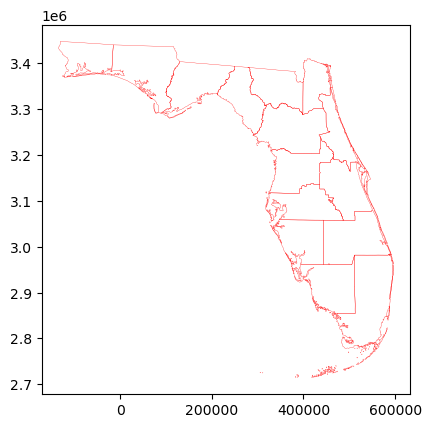

In [76]:
ax = permits_sjoined[permits_sjoined['DOF_DISTRI'].isna()].plot(markersize=2)
ffs_d.boundary.plot(color='red', linewidth=0.2, ax=ax)

In [79]:
permits_sjoined = permits_sjoined[['LATITUDE', 'LONGITUDE', 'DATE', 'BURN_TYPE', 'ACRES', 'DOF_DISTRI', 'tmmn_F', 'tmmx_F', 'etr_mm_scaled',
       'fm100_pct_scaled', 'fm1000_pct_scaled', 'pet_mm_scaled',
       'pr_mm_scaled', 'rmin_pct_scaled', 'rmax_pct_scaled', 'sph_kg_per_kg',
       'srad_W_per_m2', 'th_deg_clockwise_from_N', 'vs_m_per_s', 'vpd_kPA',
       'erc_g_unitless', 'geometry']]